<a href="https://colab.research.google.com/github/zdemanche/DLforIDS/blob/main/DLforIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-90c7999cd9b9>:39: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(file, names=column_names, skiprows=1) for file in files], ignore_index=True)
<ipython-input-3-90c7999cd9b9>:39: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(file, names=column_names, skiprows=1) for file in files], ignore_index=True)


Combined Data Shape: (2540043, 48)
   srcip          sport dstip dsport proto     state  dur  sbytes  dbytes  \
0  33661  149.171.126.9  1024    udp   CON  0.036133  528     304      31   
1   1464  149.171.126.7    53    udp   CON  0.001119  146     178      31   
2   3593  149.171.126.5    53    udp   CON  0.001209  132     164      31   
3  49664  149.171.126.0    53    udp   CON  0.001169  146     178      31   
4  32119  149.171.126.9   111    udp   CON  0.078339  568     312      31   

   sttl  ...  is_ftp_login  ct_ftp_cmd ct_srv_src  ct_srv_dst  ct_dst_ltm  \
0    29  ...             0           2          4           2           3   
1    29  ...             0          12          8           1           2   
2    29  ...             0           6          9           1           1   
3    29  ...             0           7          9           1           1   
4    29  ...             0           2          4           2           3   

   ct_src_dport_ltm  ct_dst_sport_ltm  

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           6,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 16,833 (65.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
27736/27736 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - accuracy: 0.9723 - loss: 0.0966 - val_accuracy: 0.9876 - val_loss: 0.0322
Epoch 2/5
27736/27736 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - accuracy: 0.9923 - loss: 0.0265 - val_accuracy: 0.9881 - val_loss: 0.0286
Epoch 3/5
27736/27736 ━━━━━━━━━━━━━━━━━━━━ 144s 3ms/step - accuracy: 0.9927 - loss: 0.0241 - val_accuracy: 0.9881 - val_loss: 0.0289
Epoch 4/5
27736/27736 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.9927 - loss: 0.0232 - val_accuracy: 0.9881 - val_loss: 0.0276
Epoch 5/5
27736/27736 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.9928 - loss: 0.0226 - val_accuracy: 0.9882 - val_loss: 0.0261


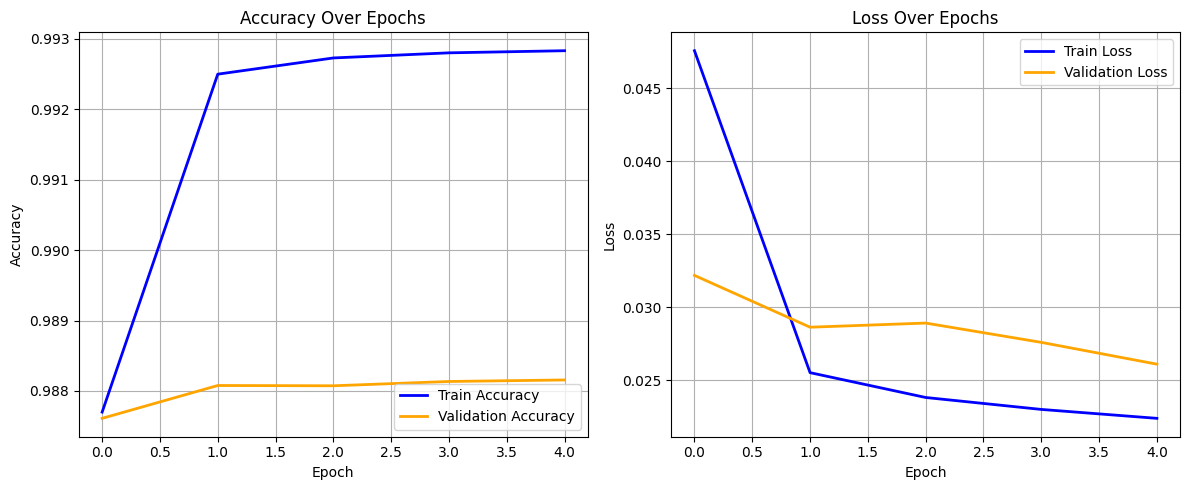

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
Test Accuracy: 0.9882
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    443669
           1       0.91      1.00      0.96     64340

    accuracy                           0.99    508009
   macro avg       0.96      0.99      0.97    508009
weighted avg       0.99      0.99      0.99    508009



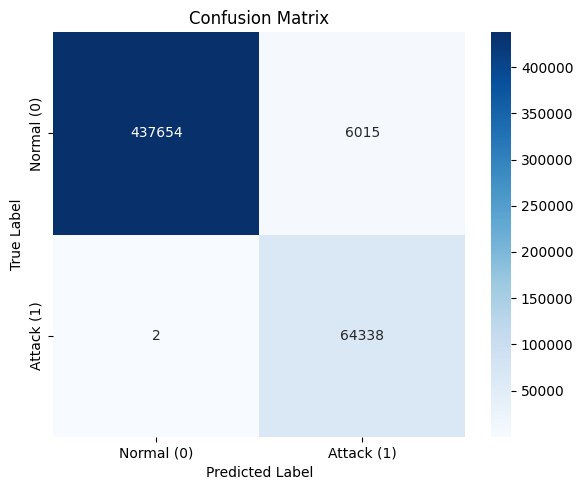

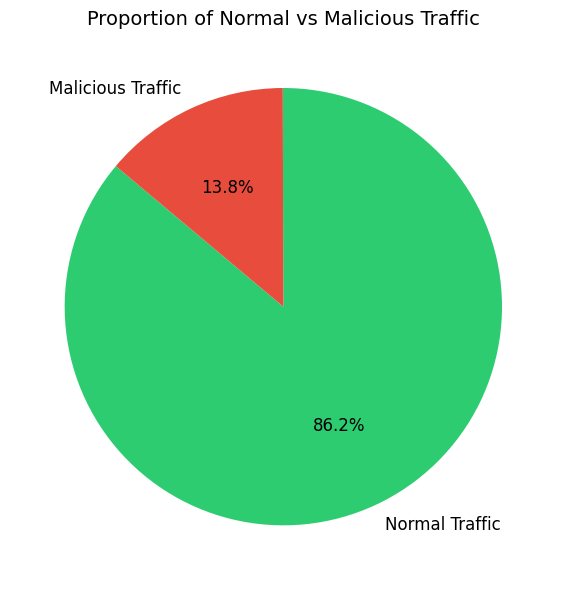

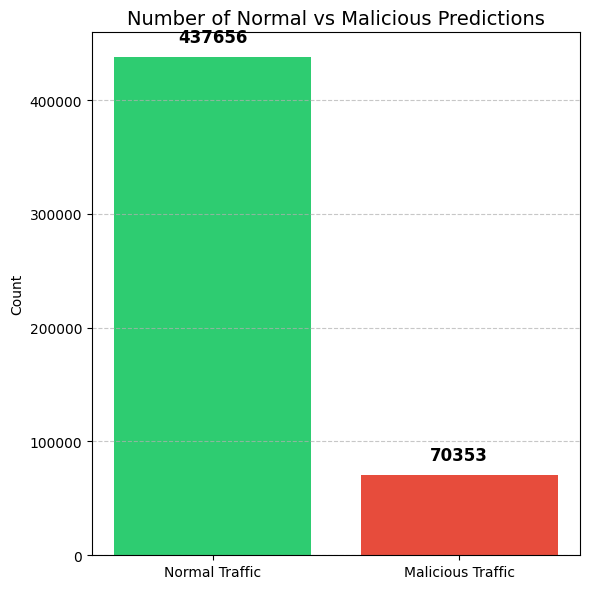

✅ Keras model saved to disk!


In [3]:
# Install additional packages if needed
!pip install imbalanced-learn seaborn matplotlib

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# For SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE

# ------------------------------------------------------------
# 1. Data Loading: Use All Four UNSW-NB15 Files
# ------------------------------------------------------------

# Define the UNSW-NB15 column names
column_names = [
    "srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes",
    "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts", "Dpkts",
    "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len",
    "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt", "synack", "ackdat",
    "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd",
    "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm",
    "ct_dst_src_ltm", "attack_cat", "label"
]

# List all UNSW NB15 files
files = ['UNSW-NB15_1.csv', 'UNSW-NB15_2.csv', 'UNSW-NB15_3.csv', 'UNSW-NB15_4.csv']

# Concatenate data from all 4 files
df = pd.concat([pd.read_csv(file, names=column_names, skiprows=1) for file in files], ignore_index=True)
print("Combined Data Shape:", df.shape)
print(df.head())

# ------------------------------------------------------------
# 2. Data Preprocessing
# ------------------------------------------------------------

# Handle missing values
df.fillna(0, inplace=True)
df["attack_cat"] = df["attack_cat"].fillna("Unknown")

# For binary classification we use "label" (0 = normal, 1 = attack)
target_column = "label"
print("✅ Using '{}' for binary classification.".format(target_column))

# Convert all categorical columns to numeric
label_encoder = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Define features X and target y
X = df.drop(columns=[target_column, "attack_cat"], errors='ignore')
y = df[target_column].astype(int)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display class distribution before SMOTE
unique, counts = np.unique(y, return_counts=True)
print("Class distribution (raw):", dict(zip(unique, counts)))

# ------------------------------------------------------------
# 3. Train-Test Split and SMOTE Oversampling
# ------------------------------------------------------------

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2,
                                                    random_state=42)
print("Training set shape before SMOTE:", X_train.shape)
print("Target distribution before SMOTE:", np.unique(y_train, return_counts=True))

# Apply SMOTE on the training data to handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Training set shape after SMOTE:", X_train_res.shape)
print("Target distribution after SMOTE:", np.unique(y_train_res, return_counts=True))

# ------------------------------------------------------------
# 4. Build and Compile the Model
# ------------------------------------------------------------

model = Sequential()

# First layer
model.add(Dense(128, input_shape=(X_train_res.shape[1],)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# Second layer
model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

# Third layer
model.add(Dense(32))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

# Output layer for binary classification with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Use an Adam optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.00005)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ------------------------------------------------------------
# 5. Train the Model with Early Stopping
# ------------------------------------------------------------

# Set up early stopping based on validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Plot training & validation accuracy and loss curves
plt.figure(figsize=(12, 5))
# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6. Evaluate the Model
# ------------------------------------------------------------

# Predict on the test set
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy and display the report
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7. Final Predictions Visualizations (Pie & Bar Charts)
# ------------------------------------------------------------

# Count predictions for each class
normal_count = (y_pred == 0).sum()
attack_count = (y_pred == 1).sum()

# Pie Chart of predictions
plt.figure(figsize=(6, 6))
plt.pie([normal_count, attack_count],
        labels=['Normal Traffic', 'Malicious Traffic'],
        colors=['#2ecc71', '#e74c3c'],
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 12})
plt.title("Proportion of Normal vs Malicious Traffic", fontsize=14)
plt.tight_layout()
plt.show()

# Bar Chart of predictions
plt.figure(figsize=(6, 6))
counts = [normal_count, attack_count]
labels = ['Normal Traffic', 'Malicious Traffic']
bars = plt.bar(labels, counts, color=['#2ecc71', '#e74c3c'])
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.03 * max(counts),
             str(count),
             ha='center', fontsize=12, fontweight='bold')
plt.title("Number of Normal vs Malicious Predictions", fontsize=14)
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. (Optional) Save the Trained Model
# ------------------------------------------------------------
model.save("IDS_UNSW15_Model.h5")
print("✅ Keras model saved to disk!")